# Test CNN models

Give average accuracies for each task, and generate confusion matrix plots.

In [1]:
import sys
sys.path.append("..")

import json
import numpy as np
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

2023-08-29 19:49:37.429091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 19:50:15.359904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from test_model import plot_cm, model_dir, output_dir
from cnn_data import load_data

Importing lots of stuff...


## Attempt confusion matrix construction

Something weird happens here.

In [7]:
def evaluate_cnn(task_name):
    print(f"Loading data for task {task_name}...")
    X_test, Y_test, _, _ = load_data(task_name)
    print(f"Loading model...")
    cnn = keras.models.load_model(f"{model_dir}/{task_name}_cnn")
    
    Y_pred = np.argmax(cnn.predict(X_test, batch_size=900), axis=1)
    
    cm = confusion_matrix(Y_test, Y_pred).astype(float)
    cm /= np.sum(cm, axis=1, keepdims=True)
    task2label = {
        "scalar1": r"$s\rightarrow\pi^0\pi^0$",
        "axion1": r"$a\rightarrow\gamma\gamma$",
        "axion2": r"$a\rightarrow3\pi^0$"
    }
    labels = [r"$\pi^0$", r"$\gamma$", task2label[task_name]]
    
    os.makedirs(f"{output_dir}/cnn", exist_ok=True)
    plot_cm(
        cm,
        labels=labels,
        save_path=f"{output_dir}/cnn/{task_name}_cm.pdf"
    )
    test_accuracy = np.mean(Y_pred == Y_test)
    print(f"\nMean test accuracy for {task_name}: {test_accuracy:.5f}")
    
    return test_accuracy, cm

Loading data for task scalar1...
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/scalar1_40-250GeV_100k.h5
Loading model...


2023-08-29 19:53:25.156193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


234/234 [==============================] - 16s 3ms/step

Mean test accuracy for scalar1: 0.94078


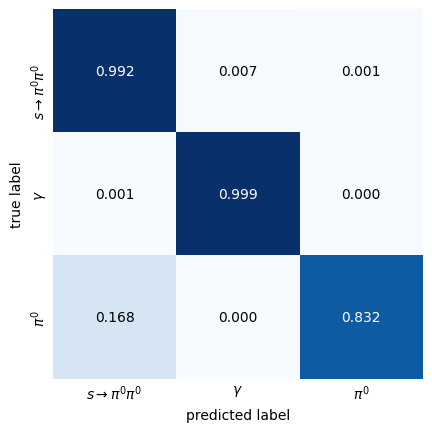

In [8]:
evaluate_cnn("scalar1");

Loading data for task axion1...
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/axion1_40-250GeV_100k.h5
Loading model...


2023-08-25 12:45:22.214094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15363 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:07:00.0, compute capability: 6.0
2023-08-25 12:45:31.987901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


234/234 [==============================] - 16s 3ms/step

Mean test accuracy for axion1: 0.80844


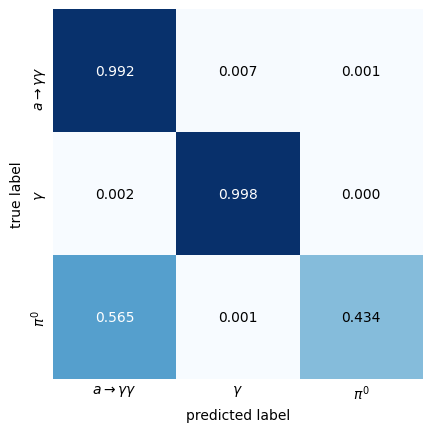

In [5]:
evaluate_cnn("axion1");

## However, using `cnn.evaluate` works perfectly fine

In [38]:
task_name = "scalar1"
cnn = keras.models.load_model(f"{model_dir}/{task_name}_cnn")
X_test, Y_test, _, _ = load_data(task_name)

print("X_test shapes:", X_test[0].shape, X_test[1].shape)
print("Y_test shape:", Y_test.shape)

load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/scalar1_40-250GeV_100k.h5
X_test shapes: (210000, 4, 16, 1) (210000, 4, 128, 1)
Y_test shape: (210000,)


Observe how `cnn.evaluate` gives >99% accuracy, but `cnn.predict` with `np.argmax` gives ~94% accuracy.

In [19]:
cnn.evaluate(X_test, Y_test, batch_size=10000)

210/210 [==============================] - 1s 4ms/step - loss: 0.0223 - acc: 0.9947


[0.022327357903122902, 0.994695246219635]

In [63]:
Y_pred = np.argmax(cnn.predict(X_test, batch_size=10000), axis=1)
correct = Y_pred == Y_test
total = len(Y_test)
print(f"{sum(correct)}/{total} correct = {(sum(correct) / total):.3f} accuracy")

21/21 [==============================] - 1s 24ms/step
197574/210000 correct = 0.941 accuracy


## What accounts for this discrepancy?

Turns out it's because sometimes, the CNN outputs `[0, 0, 0]`.

In [65]:
incorrect_idxs = np.where(Y_pred != Y_test)[0]
print(f"First 5 incorrect indices:", list(incorrect_idxs[:5]))

outputs = cnn.predict((
    X_test[0][incorrect_idxs[:5]],
    X_test[1][incorrect_idxs[:5]]
))
print(outputs)
print(f"Expected labels:  {Y_test[incorrect_idxs[:5]].astype(int)}")
print(f"Predicted labels: {Y_pred[incorrect_idxs[:5]]}")

First 5 incorrect indices: [8, 73, 89, 95, 140]
1/1 [==============================] - 0s 24ms/step
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Expected labels:  [2 2 2 2 2]
Predicted labels: [0 0 0 0 0]


In [52]:
np.argmax(outputs, axis=1)

array([2, 2, 0, 1, 1])